# Experiment Tracking with MLFlow (Local)

In this demo we will see how to use MLFlow for tracking experiments, using a toy data set. In the attached lab (below), you will download a larger dataset and attempt to train the best model that you can.

We should first install mlflow, and add it to the requirements.txt file if not done already.

`pip install mlflow` or `python3 -m pip install mlflow`.

You may also need to `pip install setuptools`.

From here, make sure to save this notebook in a specific folder, and ensure you run all command line commands from the same folder.

In [2]:
import mlflow
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_wine
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

After loading the libraries, we can first check the mlflow version you have. And, just for fun, let's look at the mlflow UI by running `mlflow ui`. After this, we should do two things:
- set the tracking uri
- create or set the experiment

Setting the tracking uri tells mlflow where to save the results of our experiments. We will first save these locally in a sqlite instance. In a future lab we will set up mlflow to run in GCP.

If you've already created an experiment previously that you'd like to use, you can tell mlflow by setting the experiment. You can also use `set_experiment` even if the experiment has not yet been created - mlflow will first check if the experiment exists, and if not, it will create it for you. 

In [3]:
mlflow.__version__

'2.15.1'

In [4]:
# !lsof -i :5000
# !ps -fp 36188 51497 56359 56360 56361 56362
# !kill -9 51497 56359 56360 56361 56362

In [5]:
# !mlflow ui 

Running the below code will create a sqlite database and an mlruns folder in the current directory.

In [6]:
import os 
os.chdir("/Users/shruti/USF-Spring-2/ML-Ops")

In [7]:
mlflow.set_tracking_uri('https://mlflow-server-295084724589.us-west2.run.app')
mlflow.set_experiment('demo-experiment')

2025/04/17 10:32:50 INFO mlflow.tracking.fluent: Experiment with name 'demo-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1744911170317, experiment_id='1', last_update_time=1744911170317, lifecycle_stage='active', name='demo-experiment', tags={}>

From here, we can load the wine data from sklearn and take a look at it. Then let's play around with some models, without using mlflow for now, to get a sense of why mlflow might come in handy.

In [8]:
wine = load_wine()
df_wine = pd.DataFrame(data=wine.data, columns=wine.feature_names)
df_wine.head(3)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0


In [9]:
y = wine.target
X = df_wine
dt = DecisionTreeClassifier(max_depth=4) # if you use a higher max_depth like 40 it will overfit 
dt.fit(X, y)

DecisionTreeClassifier(max_depth=4)

In [10]:
accuracy_score(y, dt.predict(df_wine))

0.9887640449438202

## Train a Model Using MLFLow

In this section, let's train a simple decision tree model, where we will now adjust the maximum depth (`max_depth`) of the tree, and save the results of each run of the experiment using mlflow. To do so, we need to tell mlflow to start recording. We do this with `start_run`. 

The things we might want to record in this simple case are:
- the value of `max_depth`
- the corresponding accuracy of the model

We can also tag each run to make it easier to identify them later.

After running the below code, be sure to check the mlflow UI by running the following in the terminal from the same directory as where you saved this notebook:

`mlflow ui` note that just running this you will not see any of your experiments. You must specify the uri (the place where all of your results are being stored)

`mlflow ui --backend-store-uri sqlite:///mlflow.db`

In [11]:
with mlflow.start_run():
    # log parameters and log metrics
    # parameters: hyperparameters
    # metrics: model performance metrics

    mlflow.set_tags({"Model":"decision-tree", "Train Data": "all-data"})

    tree_depth = 5
    dt = DecisionTreeClassifier(max_depth=tree_depth)
    dt.fit(X, y)
    acc = accuracy_score(y, dt.predict(df_wine))

    mlflow.log_param("max_depth", tree_depth)
    mlflow.log_metric("accuracy", acc)

mlflow.end_run()

2025/04/17 10:32:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run chill-pug-959 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/c17684847c45429d8ea4b8c7e2813330.
2025/04/17 10:32:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.


Let's do it again, but this time we'll use a random forest, which has some other hyperparameters we can tune, which makes keeping track of things a little more complex without a tool like mlflow.

In [12]:
from sklearn.ensemble import RandomForestClassifier

with mlflow.start_run():
    mlflow.set_tags({"Model":"random-forest", "Train Data": "all-data"})

    ntree = 1000
    mtry = 4

    mlflow.log_params({'n_estimators':ntree, 'max_features':mtry})

    rf = RandomForestClassifier(n_estimators = ntree, max_features = mtry, oob_score = True)
    rf.fit(X,y)
    acc = rf.oob_score_
    #acc = accuracy_score(y, rf.predict(X))
    mlflow.log_metric('accuracy', acc)

mlflow.end_run()

2025/04/17 10:32:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run hilarious-loon-760 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/85a4ab845e0341cbb1075825a930fa57.
2025/04/17 10:32:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.


Typically, in a real-world scenario, you wouldn't change your parameter values manually and re-run your code, you would either use a loop to loop through different parameter values, or you'd use a built-in method for doing cross-validation, of which there are a few. First, let's use a simple loop to run the experiment multiple times, and save the results of each run.

In [13]:
ntrees = [20,40,60,80,100]
mtrys = [3,4,5]
for i in ntrees:
    for j in mtrys:
        with mlflow.start_run():
            mlflow.set_tags({"Model":"random-forest", "Train Data": "all-data"})

            mlflow.log_params({'n_estimators':i, 'max_features':j})

            rf = RandomForestClassifier(n_estimators = i, max_features = j, oob_score = True)
            rf.fit(X,y)
            acc = rf.oob_score_
            #acc = accuracy_score(y, rf.predict(X))
            mlflow.log_metric('accuracy', acc)
        mlflow.end_run()

2025/04/17 10:32:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run youthful-fly-409 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/d73bc1693e7e43079c650f3e1ba0e2a9.
2025/04/17 10:32:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.
2025/04/17 10:32:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run rare-goose-417 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/7019730e4357475aba48c279d7ec086d.
2025/04/17 10:32:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.
2025/04/17 10:32:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run clean-moose-36 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/2bce6d702cce4130a884d2521df2ed52.
2025/04/17 10:32:52 INFO mlflow.tracking._tracking_service.client: 🧪 V

## Training a Model with mlflow and hyperopt

One way of tuning your model is to use the `hyperopt` library. `hyperopt` is a library that does hyperparameter tuning, and does so in a way that makes it easy for mlflow to keep track of the results. 

First, install the libraries you don't have, and then load them below. We do not use `hyperopt` much in the class, so if you don't want to add it to your requirements.txt file, you don't have to.

For this exercise, we'll split the data into training and validation, and then we'll train decision trees and random forests and use `hyperopt` to do the hyperparameter tuning and find the best model for us.

In [14]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

From the above we will use `cross_val_score` for our metric, `fmin` is used by `hyperopt` to do the tuning, `tpe` (Tree of Parzen Estimators) is the algorithm used to search the hyperparameter space,  `hp` has methods we need to use for defining our search space, `STATUS_OK` is a status message that each run completed, and `Trials` keeps track of each run.

In [15]:
def greet(name, age, city):
    print(f"Name: {name}, Age: {age}, City: {city}")

simple_dict = {
    "name": "Alice",
    "age": 30,
    "city": "New York"
}

# Unpacking the dictionary into function arguments
greet(**simple_dict)


Name: Alice, Age: 30, City: New York


In [16]:
def objective(params):
    with mlflow.start_run():
        classifier_type = params['type']
        del params['type'] # deletes the type from dictionary 
        if classifier_type == 'dt':
            clf = DecisionTreeClassifier(**params) # unpacks a dictionary within the context of a function
        elif classifier_type == 'rf':
            clf = RandomForestClassifier(**params)        
        else:
            return 0
        acc = cross_val_score(clf, X, y).mean()

        mlflow.set_tag("Model", classifier_type)
        mlflow.log_params(params)
        mlflow.log_metric("accuracy", acc)
        mlflow.end_run()
        return {'loss': -acc, 'status': STATUS_OK}

search_space = hp.choice('classifier_type', [
    {
        'type': 'dt',
        'criterion': hp.choice('dtree_criterion', ['gini', 'entropy']),
        'max_depth': hp.choice('dtree_max_depth', [None, hp.randint('dtree_max_depth_int', 1,10)]),
        'min_samples_split': hp.randint('dtree_min_samples_split', 2,10)
    },
    {
        'type': 'rf',
        'n_estimators': hp.randint('rf_n_estimators', 20, 500),
        'max_features': hp.randint('rf_max_features', 2,9),
        'criterion': hp.choice('criterion', ['gini', 'entropy'])
    },
])

algo = tpe.suggest
trials = Trials()

<details>
<summary>explanation</summary>
Great questions! Let's break it down step by step:

### 1. **How does it know which `classifier_type` to choose?**
   - **`search_space`** defines a search space for different models (Decision Tree or Random Forest) and their hyperparameters.
   - The `hp.choice('classifier_type', ...)` creates a choice between two possibilities:
     - One configuration for **Decision Tree** (`'type': 'dt'`).
     - Another configuration for **Random Forest** (`'type': 'rf'`).
   - During the optimization, Hyperopt will randomly pick one of the two options and sample hyperparameters for that classifier. This is what happens in each trial.
   - The classifier type (`'dt'` or `'rf'`) will be selected during each trial based on the randomly sampled options from the `search_space`.

### 2. **How are `objective` and `search_space` related?**
   - The `objective` function is passed to **Hyperopt**'s `fmin` method. Hyperopt uses this function to evaluate how well each configuration (each trial) performs.
   - The `search_space` defines the hyperparameters for each trial. Hyperopt will pick random values for these hyperparameters based on the search space you defined and pass them to the `objective` function.
   - In the `objective` function, you check the `classifier_type` (Decision Tree or Random Forest) and use the corresponding classifier configuration. The model is then trained and evaluated on some data.
   - The result of this evaluation (such as accuracy) is returned to **Hyperopt**, which tries to minimize (or maximize) the objective function. In your case, you're maximizing accuracy (using negative accuracy `-acc` as the loss).

### 3. **What does `trials` do?**
   - `trials` is an object used by **Hyperopt** to store information about each trial's outcome.
   - It keeps track of the configurations (parameters) used, the result (like accuracy), and whether the trial was successful.
   - This is useful because you can analyze how different configurations performed after the optimization finishes, and also use it for advanced features like resuming the optimization or visualizing the results.

### Example Workflow:
1. **Hyperopt starts the optimization** with `fmin`, providing the `objective` function, the `search_space`, and the `trials` object to track results.
2. **First trial**: Hyperopt picks a random configuration, for example, it might choose `classifier_type='dt'`, and sample values for `criterion`, `max_depth`, and `min_samples_split` for the Decision Tree.
3. **Objective function (`objective`)**: This configuration (with its randomly selected hyperparameters) is passed to the `objective` function, where the Decision Tree classifier is trained and evaluated. The accuracy is computed, and the negative accuracy is returned.
4. Hyperopt repeats this process for **multiple trials** (32 trials in your case).
5. **Final result**: After 32 trials, Hyperopt finds the best hyperparameter configuration based on the results stored in `trials`.

### Conclusion:
- `search_space` defines the random search space for classifiers and hyperparameters.
- The `objective` function uses the configuration provided by **Hyperopt** and evaluates the model's performance.
- `trials` tracks the performance of each configuration during the optimization process.
</details>

In [17]:
best_result = fmin(
        fn=objective, 
        space=search_space,
        algo=algo,
        max_evals=32,
        trials=trials)

  0%|          | 0/32 [00:00<?, ?trial/s, best loss=?]

2025/04/17 10:32:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run nebulous-asp-902 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/cb477616ba82472986ef5bf2f8f9dde1.

2025/04/17 10:32:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.



  3%|▎         | 1/32 [00:00<00:30,  1.00trial/s, best loss: -0.9609523809523809]

2025/04/17 10:32:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run wise-deer-191 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/b0df1212b2d6491f85bc0b19f83113b6.

2025/04/17 10:32:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.



  6%|▋         | 2/32 [00:01<00:18,  1.63trial/s, best loss: -0.9609523809523809]

2025/04/17 10:32:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run illustrious-kite-317 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/741811f93d5849d0b5b4105b77ecd8d4.

2025/04/17 10:32:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.



  9%|▉         | 3/32 [00:01<00:13,  2.09trial/s, best loss: -0.9609523809523809]

2025/04/17 10:32:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run secretive-dove-845 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/2a185cf6b8d94332aefbf3114fbba60c.

2025/04/17 10:32:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.



 12%|█▎        | 4/32 [00:01<00:11,  2.43trial/s, best loss: -0.9609523809523809]

2025/04/17 10:33:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run likeable-mink-818 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/d7e97e8fd7544234a5a60b6415c624dc.

2025/04/17 10:33:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.



 16%|█▌        | 5/32 [00:02<00:15,  1.71trial/s, best loss: -0.9720634920634922]

2025/04/17 10:33:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run bustling-koi-778 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/1b968ba8a6bf4d058bb5ebef40c8ed52.

2025/04/17 10:33:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.



 19%|█▉        | 6/32 [00:03<00:13,  1.95trial/s, best loss: -0.9720634920634922]

2025/04/17 10:33:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run bedecked-yak-313 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/fc9c427590fd4b47ac11c183d43f5b70.

2025/04/17 10:33:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.



 22%|██▏       | 7/32 [00:03<00:11,  2.22trial/s, best loss: -0.9720634920634922]

2025/04/17 10:33:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run rare-bird-308 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/7f47ef9be7ea472aa5455478467b8fe7.

2025/04/17 10:33:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.



 25%|██▌       | 8/32 [00:03<00:10,  2.23trial/s, best loss: -0.9720634920634922]

2025/04/17 10:33:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run learned-fly-214 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/cacfd572d3a3401aafd4e09741b32203.

2025/04/17 10:33:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.



 28%|██▊       | 9/32 [00:04<00:09,  2.45trial/s, best loss: -0.9720634920634922]

2025/04/17 10:33:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run capricious-mink-304 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/24a78efe6de544438d3cdf443a820a68.

2025/04/17 10:33:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.



 31%|███▏      | 10/32 [00:04<00:08,  2.57trial/s, best loss: -0.9720634920634922]

2025/04/17 10:33:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run resilient-hawk-848 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/1f20be5406964dad8f37d9a9926941f3.

2025/04/17 10:33:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.



 34%|███▍      | 11/32 [00:05<00:08,  2.49trial/s, best loss: -0.9720634920634922]

2025/04/17 10:33:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run sneaky-goose-890 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/1dda06abfb99441599d39bf25cfd192d.

2025/04/17 10:33:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.



 38%|███▊      | 12/32 [00:05<00:07,  2.62trial/s, best loss: -0.9720634920634922]

2025/04/17 10:33:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run amazing-vole-371 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/b7293a8b7bfb48d4a76aefe1d6e50f72.

2025/04/17 10:33:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.



 41%|████      | 13/32 [00:05<00:07,  2.61trial/s, best loss: -0.9720634920634922]

2025/04/17 10:33:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run clean-gnu-936 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/b47a4984fc9b41529a9af1156420bf4c.

2025/04/17 10:33:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.



 44%|████▍     | 14/32 [00:06<00:06,  2.78trial/s, best loss: -0.9720634920634922]

2025/04/17 10:33:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run redolent-toad-236 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/eb685edf18d9458db9d9a2ccbf8a3e29.

2025/04/17 10:33:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.



 47%|████▋     | 15/32 [00:07<00:12,  1.35trial/s, best loss: -0.9720634920634922]

2025/04/17 10:33:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run rambunctious-yak-606 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/c949685d32a04ee1a65fe369ee9e652b.

2025/04/17 10:33:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.



 50%|█████     | 16/32 [00:08<00:09,  1.65trial/s, best loss: -0.9720634920634922]

2025/04/17 10:33:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run receptive-wolf-734 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/84898d65a2b142c2816b8f7beb312bcd.

2025/04/17 10:33:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.



 53%|█████▎    | 17/32 [00:08<00:10,  1.48trial/s, best loss: -0.9720634920634922]

2025/04/17 10:33:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run vaunted-perch-435 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/97bbda1812c244c08f2729756529eb99.

2025/04/17 10:33:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.



 56%|█████▋    | 18/32 [00:09<00:07,  1.80trial/s, best loss: -0.9720634920634922]

2025/04/17 10:33:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run colorful-grub-216 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/ce37794cd02a4f74a7bde734d72ad77a.

2025/04/17 10:33:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.



 59%|█████▉    | 19/32 [00:10<00:10,  1.25trial/s, best loss: -0.9720634920634922]

2025/04/17 10:33:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run bedecked-turtle-993 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/9b7d0d426e044a0383d77510a2c8df34.

2025/04/17 10:33:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.



 62%|██████▎   | 20/32 [00:11<00:10,  1.12trial/s, best loss: -0.9720634920634922]

2025/04/17 10:33:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run stylish-pug-622 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/cb2eec100e4c4d508ec77420d5fc3aa3.

2025/04/17 10:33:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.



 66%|██████▌   | 21/32 [00:12<00:10,  1.08trial/s, best loss: -0.9720634920634922]

2025/04/17 10:33:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run enchanting-stoat-966 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/3c726738bd34485da80f8d77cae3de83.

2025/04/17 10:33:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.



 69%|██████▉   | 22/32 [00:13<00:09,  1.01trial/s, best loss: -0.9776190476190475]

2025/04/17 10:33:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run serious-goose-299 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/6318552c9e394fd58d1ca868bc525744.

2025/04/17 10:33:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.



 72%|███████▏  | 23/32 [00:14<00:09,  1.01s/trial, best loss: -0.9776190476190475]

2025/04/17 10:33:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run rebellious-sow-364 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/27437fe960eb4352b13bcb8e30de4e93.

2025/04/17 10:33:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.



 75%|███████▌  | 24/32 [00:15<00:08,  1.04s/trial, best loss: -0.9776190476190475]

2025/04/17 10:33:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run stately-slug-118 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/27129bf8061347caa2b5f0695a94cd81.

2025/04/17 10:33:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.



 78%|███████▊  | 25/32 [00:16<00:06,  1.13trial/s, best loss: -0.9833333333333332]

2025/04/17 10:33:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run bald-vole-221 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/a3bd75f2d11946088ed8d664b08090d1.

2025/04/17 10:33:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.



 81%|████████▏ | 26/32 [00:17<00:05,  1.04trial/s, best loss: -0.9833333333333332]

2025/04/17 10:33:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run welcoming-finch-998 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/8cadea1f69b941bebc50fde458cab343.

2025/04/17 10:33:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.



 84%|████████▍ | 27/32 [00:18<00:04,  1.14trial/s, best loss: -0.9888888888888889]

2025/04/17 10:33:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run rebellious-duck-15 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/5ce345c9fc164559b68cf9db0ead258d.

2025/04/17 10:33:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.



 88%|████████▊ | 28/32 [00:19<00:03,  1.04trial/s, best loss: -0.9888888888888889]

2025/04/17 10:33:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run calm-squirrel-170 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/2dff9c69941d4719843fccd09ccca612.

2025/04/17 10:33:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.



 91%|█████████ | 29/32 [00:20<00:03,  1.07s/trial, best loss: -0.9888888888888889]

2025/04/17 10:33:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run masked-zebra-212 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/26235539f4284d9d8b2e0fae21a23c79.

2025/04/17 10:33:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.



 94%|█████████▍| 30/32 [00:21<00:02,  1.01s/trial, best loss: -0.9888888888888889]

2025/04/17 10:33:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run beautiful-cow-880 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/0be28fc0b1064d35a9f64e1a7a5782b6.

2025/04/17 10:33:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.



 97%|█████████▋| 31/32 [00:22<00:00,  1.11trial/s, best loss: -0.9888888888888889]

2025/04/17 10:33:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run wistful-goose-215 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/7bce8e00eace4ecaa2ea1a6e93669a45.

2025/04/17 10:33:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.



100%|██████████| 32/32 [00:23<00:00,  1.37trial/s, best loss: -0.9888888888888889]


In [18]:
best_result

{'classifier_type': 1,
 'criterion': 1,
 'rf_max_features': 2,
 'rf_n_estimators': 157}

### Using Autologging

Rather than manually logging parameters and metrics, mlflow has an autolog feature, which is compatible with a subset of python libraries, such as sklearn. Autologging makes it easy to log all of the important stuff, without having to manually write lines of code to log the parameters. However, sometimes you will want to have finer control over what gets logged, and should instead skip autologging.

In [19]:
with mlflow.start_run():
    mlflow.sklearn.autolog()
    tree_depth = 5
    dt = DecisionTreeClassifier(max_depth=tree_depth)
    dt.fit(X_train, y_train)
    mlflow.sklearn.autolog(disable=True)
mlflow.end_run()

2025/04/17 10:33:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/shruti/.pyenv/versions/mlops/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
2025/04/17 10:33:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run delightful-fawn-218 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/673e966b75d14f2d9c5b7c51ba085be8.
2025/04/17 10:33:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.


# Artifact Tracking and Model Registry (Local)

In this section we will save some artifacts from our model as we go through the model development process. There are a few things that might be worth saving, such as datasets, plots, and the final model itself that might go into production later.

## Data

First, let's see how we can store our important datasets, in a compressed format, for use for later, for example, in case we get a new request about our model and need to run some analyses (such as "what is the distribution of this feature, but only for this specific subset of data?" or "how did the model do on these particular observations from your validation set?").

In [20]:
import os 
os.chdir("/Users/shruti/USF-Spring-2/ML-Ops/notebooks")
os.makedirs('save_data', exist_ok = True)

X_train.to_parquet('save_data/x_train.parquet')

mlflow.log_artifact('save_data/x_train.parquet') # artifcat: any output from your experiment

In [21]:
X_test.to_parquet('save_data/x_test.parquet')

mlflow.log_artifacts('save_data/')

You can now go to the mlflow UI, click on the latest run, and select the Artifacts tab. You should see something similar to this:
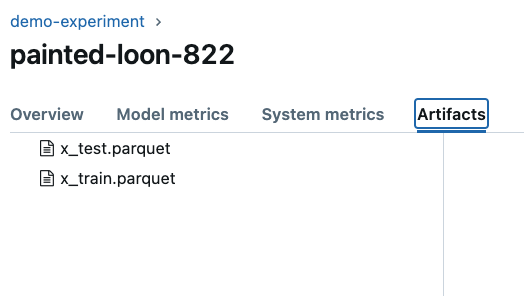

## Images

As part of the model dev process you may end up creating visualizations that can be useful for analysis, or for reporting. You can use mlflow to log the important ones and ignore the rest. After creating the below figure, save into a folder called images, and then you can log whatever is in the `images` folder as an artifact.

array([[<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>]], dtype=object)

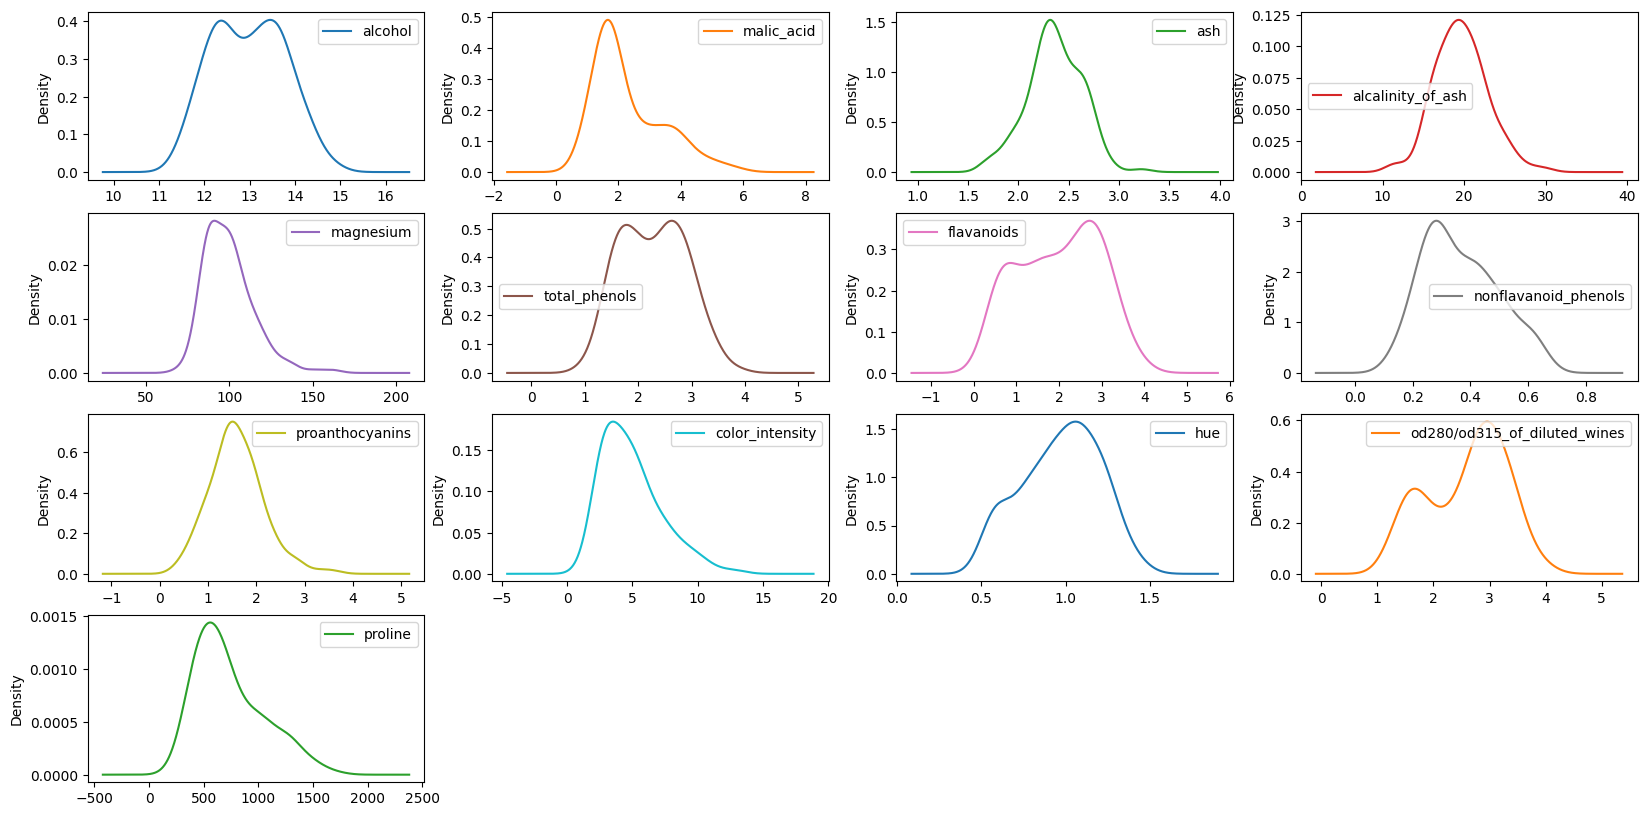

In [22]:
%matplotlib inline
os.makedirs('images', exist_ok = True)
X_train.plot.density(subplots = True, figsize = (20,10), layout = (4,4), sharey = False, sharex = False)

In [24]:
# with mlflow.start_run():
#     mlflow.log_artifacts('images')
# mlflow.end_run()

Notice how all of the artifacts were saved in the same run of the experiment. We could have added an `mlflow.end_run()` in between our `log_artifacts` lines to separate runs if we wanted to.

## Model Management and Model Registry

As you are developing your models you may want to save certain versions of the model, or maybe even all of them, so that you don't have to go back and retrain them later. We can do this in mlflow by logging the models, not as artifacts, but as models, using `log_model`. 

In this section we'll log a couple of models to see how mlflow handles model management. Above, we used `hyperopt` to train a bunch of models at once. Let's do this again, and log some of the models that we train.

### Logging as an Artifact

First we can try logging a model as an artifact. To do this, we must first save the model itself, which we can do by using the `pickle` library. We then log the model as an artifact like we did with data and images. 

In [ ]:
import pickle

os.makedirs('../models', exist_ok = True)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

with open('../models/model.pkl','wb') as f:
    pickle.dump(dt,f)

# First we'll log the model as an artifact
mlflow.log_artifact('../models/model.pkl', artifact_path='my_models')

### Logging as a Model

Logging the model as an artifact only logs the pickle file (the serialized version of the model). It's not really very useful, especially since models contain so much metadata that might be critical to know for deploying the model later. mlflow has a built-in way of logging models specifically, so let's see how to use this, and how it's different from logging models as an artifact.

In [ ]:
# Let's do it again, but this time we will log the model using log_model
mlflow.sklearn.log_model(dt, artifact_path = 'better_models')
mlflow.end_run()

Ok, so if you go to the mlflow UI at this point you can see the difference in `log_artifact`, which simply logs the pickle file, and `log_model`, which also gives you information about the environment, required packages, and model flavor.

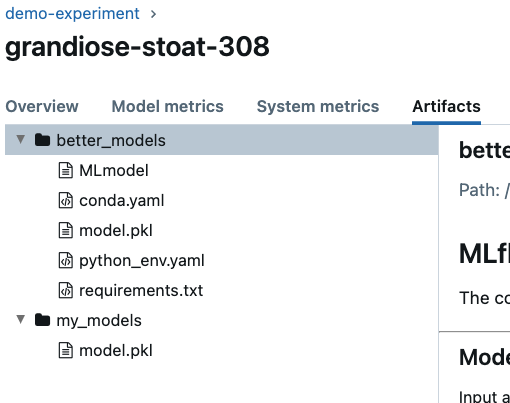

Let's do this one more time, but this time let's use `hyperopt` and log all of the trained models separately. Let's do this in a new experiment called 'demo-experiment2'. 

In [ ]:
mlflow.set_experiment('demo-experiment2')
def objective(params):
    with mlflow.start_run():
        classifier_type = params['type']
        del params['type']
        if classifier_type == 'dt':
            clf = DecisionTreeClassifier(**params)
        elif classifier_type == 'rf':
            clf = RandomForestClassifier(**params)        
        else:
            return 0
        acc = cross_val_score(clf, X, y).mean()

        mlflow.set_tag("Model", classifier_type)
        mlflow.log_params(params)
        mlflow.log_metric("accuracy", acc)
        mlflow.sklearn.log_model(clf, artifact_path = 'better_models')
        mlflow.end_run()
        return {'loss': -acc, 'status': STATUS_OK}
search_space = hp.choice('classifier_type', [
    {
        'type': 'dt',
        'criterion': hp.choice('dtree_criterion', ['gini', 'entropy']),
        'max_depth': hp.choice('dtree_max_depth', [None, hp.randint('dtree_max_depth_int', 1,10)]),
        'min_samples_split': hp.randint('dtree_min_samples_split', 2,10)
    },
    {
        'type': 'rf',
        'n_estimators': hp.randint('rf_n_estimators', 20, 500),
        'max_features': hp.randint('rf_max_features', 2,9),
        'criterion': hp.choice('criterion', ['gini', 'entropy'])
    },
])

algo = tpe.suggest
trials = Trials()
best_result = fmin(
        fn=objective, 
        space=search_space,
        algo=algo,
        max_evals=32,
        trials=trials)

<details> <summary> EXPLANATION OF MAX_EVALS AND ALGO  </summary>

### What Does `max_evals=32` Mean?
- **`max_evals=32`** means that Hyperopt will try **32 different combinations** of hyperparameters. 
- If there are 36 possible combinations in the **search space**, Hyperopt will still only explore **32** of them (and it may choose to not explore some combinations if it doesn't find them to be optimal).
- Hyperopt will search the hyperparameter space intelligently, using algorithms like **TPE** (Tree-structured Parzen Estimator) to decide which hyperparameters to try next, rather than trying all 36 combinations randomly or exhaustively.
- So, even if there are 36 possibilities, **`max_evals=32`** caps the number of combinations it will explore.

### Other Algorithms in Hyperopt

Hyperopt supports several algorithms to search the hyperparameter space efficiently. The algorithm you’ve been using so far is **TPE (Tree-structured Parzen Estimator)**, but Hyperopt supports a couple of other algorithms as well:

1. **Random Search** (`rand.suggest`):
   - This is a basic search method that randomly samples hyperparameters from the search space. It's simple but can be inefficient for large or complex search spaces.
   - **Pros**: Can explore a large space, but doesn't leverage any previous trials to guide future searches.
   - **Cons**: Can be inefficient in finding the optimal solution compared to more sophisticated methods like TPE or Adaptive TPE.
   
   ```python
   algo = rand.suggest
   ```

2. **Tree-structured Parzen Estimator (TPE)** (`tpe.suggest`):
   - **TPE** is a **Bayesian optimization** algorithm that models the distribution of good and bad hyperparameter configurations. It builds probabilistic models to guide the search towards better regions of the hyperparameter space.
   - **Pros**: More efficient than random search; it intelligently balances exploration and exploitation of the hyperparameter space.
   - **Cons**: Requires more evaluations to find the global optimum compared to random search in some cases.
   
   ```python
   algo = tpe.suggest
   ```

3. **Adaptive TPE (ATPE)** (`atpe.suggest`):
   - Adaptive TPE is an enhanced version of the original TPE. It improves on TPE by using both the **best-performing** and **worst-performing** hyperparameter configurations to build its model. 
   - **Pros**: Generally performs better than TPE, especially in larger or more complex spaces.
   - **Cons**: More computationally expensive than regular TPE.
   
   ```python
   algo = atpe.suggest
   ```

4. **Gaussian Process (GP)** (`gp.suggest`):
   - This method uses **Gaussian Processes** to model the function of hyperparameters that you are trying to optimize. It's another method for **Bayesian optimization**, but it requires more calculations per trial and is usually slower than TPE.
   - **Pros**: Works well for low-dimensional spaces (fewer hyperparameters).
   - **Cons**: Can become slow for higher-dimensional spaces (many hyperparameters to tune).
   
   ```python
   algo = gp.suggest
   ```

### Summary of Algorithms
- **Random Search** (`rand.suggest`): Randomly picks values from the search space.
- **Tree-structured Parzen Estimator (TPE)** (`tpe.suggest`): A probabilistic model-based approach, works efficiently by balancing exploration and exploitation.
- **Adaptive TPE (ATPE)** (`atpe.suggest`): A more advanced version of TPE that generally performs better by considering both good and bad configurations.
- **Gaussian Process (GP)** (`gp.suggest`): A method based on Gaussian Processes, works well for low-dimensional search spaces.

### How These Algorithms Work
Each algorithm aims to **search the hyperparameter space efficiently**:
- **Random Search** explores the space randomly.
- **TPE** builds a probabilistic model of the hyperparameter space and suggests new combinations based on previous trials, focusing on areas that have worked well.
- **Gaussian Process** and **Adaptive TPE** also aim to balance **exploration** (trying new, unknown areas of the space) and **exploitation** (focusing on areas known to work well).

### When to Use Which Algorithm:
- **Random Search** is useful when you have a simple or small search space and want to explore it quickly.
- **TPE** is often the default choice and works well for most hyperparameter tuning problems, especially in medium to large search spaces.
- **Adaptive TPE** is better if you're dealing with more complex problems, or you have a larger search space and want even better performance.
- **Gaussian Process** is useful for **low-dimensional** hyperparameter spaces (few parameters) and when you need more accurate modeling.

The main idea of these algorithms is to intelligently explore the hyperparameter space to find the best model configuration. By using methods like **TPE**, Hyperopt can search more efficiently than simple **random search**, making it ideal for tuning models in complex or large search spaces.
</details>

### Loading Models

Now that models have been logged, you can load specific models back into python for predicting and further analysis. There are two main ways to do this. The mlflow UI actually gives you some instructions, with code that you copy and paste.

In [ ]:
logged_model = 'runs:/7ce75c302a9e4602aee4e673c124f127/better_models' #replace with one of your models

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model

In [ ]:
sklearn_model = mlflow.sklearn.load_model(logged_model)
sklearn_model

In [ ]:
sklearn_model.fit(X_train, y_train)
preds = sklearn_model.predict(X_test)
preds[:5]

### Model Registry

Typically, you will **register** your *chosen* model, the model you plan to put into production. But, sometimes, after you've chosen and registered a model, you may need to replace that model with a new version. For example, the model may have gone into production and started to degrade in performance, and so the model needed to be retrained. Or, you go to deploy your model and notice an error or bug, and now have to go back and retrain it.

In this section let's see how we take our logged models and register them in the model registry, which then can get picked up by the production process, or engineer, for deployment. First, I'll demonstrate how this is done within the UI, but then below I'll show how we can use the python API to do the same thing.

In [ ]:
runid = '7ce75c302a9e4602aee4e673c124f127'
mod_path = f'runs:/{runid}/artifacts/better_models'
mlflow.register_model(model_uri = mod_path, name = 'wine_model_from_nb')

## Common Issues

- Nothing is appearing in the MLFlow UI: make sure you start the UI from the directory where your notebook is running.  
- I installed a library, but I'm getting an error loading it: be sure you installed it in the same environment as where your notebook is running.  
- MLFlow doesn't seem to be working at all, I'm just getting errors all over the place: this might be a versioning issue.  
- The UI broke, I can't get back to it: `sudo lsof -i :5000 | awk '{print $2}' | tail -n +2 | xargs kill`



# Experiment Tracking and Model Registry Lab

## Overview

In this lab you will each download a new dataset and attempt to train a good model, and use mlflow to keep track of all of your experiments, log your metrics, artifacts and models, and then register a final set of models for "deployment", though we won't actually deploy them anywhere yet.

## Goal

Your goal is **not** to become a master at MLFlow - this is not a course on learning all of the ins and outs of MLFlow. Instead, your goal is to understand when and why it is important to track your model development process (tracking experiments, artifacts and models) and to get into the habit of doing so, and then learn at least the basics of how MLFlow helps you do this so that you can then compare with other tools that are available.

## Data

You can choose your own dataset to use here. It will be helpful to choose a dataset that is already fairly clean and easy to work with. You can even use a dataset that you've used in a previous course. We will do a lot of labs where we do different things with datasets, so if you can find one that is interesting enough for modeling, it should work for most of the rest of the course. 

There are tons of places where you can find open public datasets. Choose something that interests you, but don't overthink it.

[Kaggle Datasets](https://www.kaggle.com/datasets)  
[HuggingFace Datasets](https://huggingface.co/docs/datasets/index)  
[Dagshub Datasets](https://dagshub.com/datasets/)  
[UCI](https://archive.ics.uci.edu/ml/datasets.php)  
[Open Data on AWS](https://registry.opendata.aws/)  
[Yelp](https://www.yelp.com/dataset)  
[MovieLens](https://grouplens.org/datasets/movielens/)  
And so many more...

## Instructions

Once you have selected a set of data, create a brand new experiment in MLFlow and begin exploring your data. Do some EDA, clean up, and learn about your data. You do not need to begin tracking anything yet, but you can if you want to (e.g. you can log different versions of your data as you clean it up and do any feature engineering). Do not spend a ton of time on this part. Your goal isn't really to build a great model, so don't spend hours on feature engineering and missing data imputation and things like that.

Once your data is clean, begin training models and tracking your experiments. If you intend to use this same dataset for your final project, then start thinking about what your model might look like when you actually deploy it. For example, when you engineer new features, be sure to save the code that does this, as you will need this in the future. If your final model has 1000 complex features, you might have a difficult time deploying it later on. If your final model takes 15 minutes to train, or takes a long time to score a new batch of data, you may want to think about training a less complex model.

Now, when tracking your experiments, at a *minimum*, you should:

1. Try at least 3 different ML algorithms (e.g. linear regression, decision tree, random forest, etc.).
2. Do hyperparameter tuning for **each** algorithm.
3. Do some very basic feature selection, and repeat the above steps with these reduced sets of features.
4. Identify the top 3 best models and note these down for later.
6. Choose the **final** "best" model that you would deploy or use on future data, stage it (in MLFlow), and run it on the test set to get a final measure of performance. Don't forget to log the test set metric.
7. Be sure you logged the exact training, validation, and testing datasets for the 3 best models, as well as hyperparameter values, and the values of your metrics.  
8. Push your code to Github. No need to track the mlruns folder, the images folder, any datasets, or the sqlite database in git.

### Turning It In

In the MLFlow UI, next to the refresh button you should see three vertical dots. Click the dots and then download your experiments as a csv file. Open the csv file in Excel and highlight the rows for your top 3 models from step 4, highlight the run where you applied your best model to the test set, and then save as an excel file. Take a snapshot of the Models page in the MLFLow UI showing the model you staged in step 6 above. Submit the excel file and the snapshot to Canvas.

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 
        * Simple demographic info for the users (age, gender, occupation, zip)

In [32]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
           'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
           'hours-per-week', 'native-country', 'income']

df = pd.read_csv("/Users/shruti/Downloads/adult/adult.data", header=None, names=columns, na_values=" ?", skipinitialspace=True)
df.dropna(inplace=True)

df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [33]:
print("Original df shape:", df.shape)
df = pd.get_dummies(df, drop_first=True)
print("Dummies df shape", df.shape)
df.head()

Original df shape: (32561, 15)
Dummies df shape (32561, 101)


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,income_>50K
0,39,77516,13,2174,0,40,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,50,83311,13,0,0,13,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,38,215646,9,0,0,40,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
3,53,234721,7,0,0,40,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
4,28,338409,13,0,0,40,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [34]:
# Target variable: income > 50K (binary classification)
X = df.drop('income_>50K', axis=1)  
y = df['income_>50K']  

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [ ]:
# you don't have to scale if it's not regularization (necessarily), but logistic regression NEEDS scaling and rf and dt are indifferent 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [38]:
# # For the first experiment
# os.chdir("/Users/shruti/USF-Spring-2/ML-Ops")
# mlflow.set_tracking_uri('sqlite:////Users/shruti/USF-Spring-2/ML-Ops/mlflow.db')
# mlflow.set_experiment('demo-experiment')

# # For the second experiment
# os.chdir("/Users/shruti/USF-Spring-2/ML-Ops/notebooks")
# mlflow.set_tracking_uri('sqlite:////Users/shruti/USF-Spring-2/ML-Ops/notebooks/mlflow.db')
# mlflow.set_experiment('adult_income_experiment')

# mlflow.set_tracking_uri('sqlite:////Users/shruti/USF-Spring-2/ML-Ops/notebooks/mlflow.db')
mlflow.set_tracking_uri('https://mlflow-server-295084724589.us-west2.run.app')
mlflow.set_experiment('adult_income_experiment')

<Experiment: artifact_location='mlflow-artifacts:/2', creation_time=1744914259741, experiment_id='2', last_update_time=1744914259741, lifecycle_stage='active', name='adult_income_experiment', tags={}>

In [39]:
mlflow.end_run()

2025/04/17 11:24:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run carefree-auk-87 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1/runs/d6c7b55f463b45a8bfff9c0045d52e53.
2025/04/17 11:24:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/1.


#### **ML Algorithms**

In [40]:
# Decision Tree
with mlflow.start_run():
    for max_depth in [1,3,5]:
        model = DecisionTreeClassifier(max_depth=max_depth)
        model.fit(X_train_scaled, y_train)
        
        y_hat= model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_hat)
        
        mlflow.set_tags({"Model":"decision-tree", "Train Data": "training-data"})
        mlflow.log_metric('accuracy', accuracy)
        
        print(f'Accuracy: {accuracy}')
mlflow.end_run()

Accuracy: 0.756333486872409
Accuracy: 0.8427759864885613


2025/04/17 11:24:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run gentle-dog-154 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/9a8f866be6994bd79f05851d003b4bf4.
2025/04/17 11:24:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.


Accuracy: 0.849531705819131


In [41]:
# Random Forest 
ntrees = [20,40,60,80,100]
mtrys = [3,4,5]
for i in ntrees:
    for j in mtrys:
        with mlflow.start_run():
            
            mlflow.log_params({'n_estimators':i, 'max_features':j})
            rf = RandomForestClassifier(n_estimators = i, max_features = j, oob_score = True)
            rf.fit(X_train_scaled,y_train)
            acc = rf.oob_score_

            mlflow.set_tags({"Model":"random-forest", "Train Data": "training-data"})
            mlflow.log_metric('accuracy', acc)
        mlflow.end_run()

/Users/shruti/.pyenv/versions/mlops/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
2025/04/17 11:24:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run traveling-elk-591 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/534416aafc084594a3d1bbfedc4bb971.
2025/04/17 11:24:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.
/Users/shruti/.pyenv/versions/mlops/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
2025/04/17 11:24:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run adorable-mule-786 at: https://mlflow-server-295084724589.us-west2.run.app/#/exper

In [42]:
# Logistic Regression
with mlflow.start_run():
    model = LogisticRegression(max_iter=500)
    model.fit(X_train_scaled, y_train)
    
    y_hat= model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_hat)

    mlflow.set_tags({"Model":"logistic-regression", "Train Data": "training-data"})
    mlflow.sklearn.log_model(model, 'logistic regression')
    mlflow.log_metric('accuracy', accuracy)
    
    print(f'Accuracy: {accuracy}')
mlflow.end_run()

2025/04/17 11:25:11 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/04/17 11:25:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run nimble-koi-617 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/ed86f371749d4ca1923718b945275e10.
2025/04/17 11:25:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.


Accuracy: 0.8498387839705205


#### **Hyperparameter Tuning**

In [43]:
def objective(params):
    with mlflow.start_run():
        classifier_type = params['type']
        del params['type']  

        if classifier_type == 'dt':
            clf = DecisionTreeClassifier(**params)
        elif classifier_type == 'rf':
            clf = RandomForestClassifier(**params)
        elif classifier_type == 'lr':
            clf = LogisticRegression(**params)
        else:
            return 0  
        
        acc = cross_val_score(clf, X_train_scaled, y_train).mean()

        mlflow.set_tag("Model", classifier_type)
        mlflow.log_params(params)
        mlflow.log_metric("accuracy", acc)
        
    mlflow.end_run()
    return {'loss': -acc, 'status': STATUS_OK}


search_space = hp.choice('classifier_type', [
    {
        'type': 'dt',
        'criterion': hp.choice('dtree_criterion', ['gini', 'entropy']),
        'max_depth': hp.choice('dtree_max_depth', 
            [None] + list(range(1, 11))), 
        'min_samples_split': hp.randint('dtree_min_samples_split', 2, 10)
    },
    {
        'type': 'rf',
        'n_estimators': hp.randint('rf_n_estimators', 20, 500),
        'max_features': hp.randint('rf_max_features', 2, 9),
        'criterion': hp.choice('criterion', ['gini', 'entropy'])
    },
    {
        'type': 'lr',
        'C': hp.loguniform('lr_C', np.log(1e-5), np.log(1e5)),  
        'penalty': hp.choice('lr_penalty', ['l1', 'l2']),
        'solver': hp.choice('lr_solver', ['liblinear']),
        'max_iter': hp.choice('lr_max_iter', [100, 200, 500, 1000])
    }
])

In [44]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=20,
    trials=Trials()
)

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

2025/04/17 11:25:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run loud-cow-251 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/9896b924ca74482181c8956eb3014806.

2025/04/17 11:25:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



  5%|▌         | 1/20 [00:23<07:19, 23.11s/trial, best loss: -0.8528483220942344]

2025/04/17 11:26:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run abrasive-mule-254 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/1dfad6c12acc4c5196d84699cf84c9ff.

2025/04/17 11:26:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 10%|█         | 2/20 [00:52<07:57, 26.55s/trial, best loss: -0.8528483220942344]

2025/04/17 11:26:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run bright-wolf-897 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/29f3b507ab8043de82af7190b2502f6b.

2025/04/17 11:26:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 15%|█▌        | 3/20 [01:00<05:07, 18.10s/trial, best loss: -0.8528483220942344]

2025/04/17 11:26:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run languid-toad-382 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/3458aaa0989e4fff8765741e483319cc.

2025/04/17 11:26:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 20%|██        | 4/20 [01:00<02:57, 11.11s/trial, best loss: -0.8528483220942344]

2025/04/17 11:26:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run overjoyed-hare-658 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/d30d2a786fc74153bf5ffc9a5ca1dd3f.

2025/04/17 11:26:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 25%|██▌       | 5/20 [01:04<02:08,  8.57s/trial, best loss: -0.8528483220942344]

2025/04/17 11:26:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run clumsy-colt-381 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/6e1cc0a0fd7141ed9680ef83c5662c5a.

2025/04/17 11:26:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 30%|███       | 6/20 [01:05<01:22,  5.89s/trial, best loss: -0.8533091515533613]

2025/04/17 11:26:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run incongruous-goat-116 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/f5c21b206f7740358b364fae29f4059c.

2025/04/17 11:26:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 35%|███▌      | 7/20 [01:05<00:54,  4.20s/trial, best loss: -0.8533091515533613]

2025/04/17 11:26:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run righteous-fish-520 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/f4d4b8f8cf8245dab5a614d98544fe02.

2025/04/17 11:26:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 40%|████      | 8/20 [01:07<00:39,  3.32s/trial, best loss: -0.8533091515533613]

2025/04/17 11:26:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run overjoyed-skunk-292 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/d444af8748cb49ceb630b02d8745f566.

2025/04/17 11:26:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 45%|████▌     | 9/20 [01:08<00:27,  2.51s/trial, best loss: -0.8536929255396959]

2025/04/17 11:26:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run welcoming-doe-169 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/6d9d7038df8d4adcb1333beb0589a75c.

2025/04/17 11:26:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 50%|█████     | 10/20 [01:11<00:26,  2.69s/trial, best loss: -0.8536929255396959]

2025/04/17 11:26:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run bittersweet-calf-927 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/ebc6ee99320542f2954a12f0b16e9934.

2025/04/17 11:26:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 55%|█████▌    | 11/20 [01:13<00:21,  2.41s/trial, best loss: -0.8536929255396959]

2025/04/17 11:26:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run sneaky-mole-958 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/94eb45c579db45099d8c8e6f878bd586.

2025/04/17 11:26:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 60%|██████    | 12/20 [01:26<00:45,  5.74s/trial, best loss: -0.8536929255396959]

2025/04/17 11:26:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run stately-hog-994 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/9c593be53cae41feba75a36d50d97a2f.

2025/04/17 11:26:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 65%|██████▌   | 13/20 [01:28<00:33,  4.77s/trial, best loss: -0.8536929255396959]

2025/04/17 11:27:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run able-penguin-995 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/da0bade6f5a84c7593f8be4b4e4e0834.

2025/04/17 11:27:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 70%|███████   | 14/20 [01:58<01:13, 12.28s/trial, best loss: -0.8557276955689787]

2025/04/17 11:27:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run honorable-grub-105 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/1832ccbf388a4227abb7d3a1ca9895d1.

2025/04/17 11:27:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 75%|███████▌  | 15/20 [02:30<01:30, 18.20s/trial, best loss: -0.8557276955689787]

2025/04/17 11:27:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run honorable-snail-191 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/e171b2dd45444c8dba6f3fdbe94fcdda.

2025/04/17 11:27:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 80%|████████  | 16/20 [02:41<01:04, 16.06s/trial, best loss: -0.8557276955689787]

2025/04/17 11:27:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run magnificent-bird-480 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/4573648391c9476fa4bb593662089608.

2025/04/17 11:27:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 85%|████████▌ | 17/20 [02:44<00:36, 12.14s/trial, best loss: -0.8557276955689787]

2025/04/17 11:27:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run defiant-bear-858 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/1e11b5cef79e49dd98882f60ad7a6a3c.

2025/04/17 11:27:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 90%|█████████ | 18/20 [02:47<00:18,  9.41s/trial, best loss: -0.8557276955689787]

2025/04/17 11:28:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run victorious-midge-951 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/a8c8bc0c18cc4cb380286b338d556945.

2025/04/17 11:28:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 95%|█████████▌| 19/20 [02:55<00:08,  8.98s/trial, best loss: -0.8557276955689787]

2025/04/17 11:28:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run dazzling-crab-325 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/164a89d607d04be794a84fb161c30895.

2025/04/17 11:28:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



100%|██████████| 20/20 [02:56<00:00,  8.81s/trial, best loss: -0.8557276955689787]


In [45]:
best_result

{'classifier_type': 1,
 'criterion': 1,
 'rf_max_features': 8,
 'rf_n_estimators': 364}

In [46]:
# Fitting best model
best_model = RandomForestClassifier(max_features=8, n_estimators=364)
best_model.fit(X_train_scaled, y_train)

RandomForestClassifier(max_features=8, n_estimators=364)

In [47]:
accuracy = best_model.score(X_test_scaled, y_test)
print("Test accuracy:", accuracy)

Test accuracy: 0.8550591125441425


#### **Feature Seleciton**

In [48]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.01)  

lasso.fit(X_train_scaled, y_train)
coefficients = lasso.coef_
non_zero_indices = np.where(coefficients != 0)[0]

selected_features = df.columns[non_zero_indices]
print(f'Selected Features: {selected_features}')

Selected Features: Index(['age', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass_Federal-gov', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'education_Doctorate',
       'education_HS-grad', 'education_Masters', 'education_Prof-school',
       'marital-status_Married-civ-spouse', 'marital-status_Never-married',
       'occupation_Exec-managerial', 'occupation_Farming-fishing',
       'occupation_Prof-specialty', 'occupation_Protective-serv',
       'occupation_Sales', 'occupation_Tech-support', 'relationship_Wife',
       'sex_Male'],
      dtype='object')


In [49]:
reduced_df = df[selected_features]
reduced_df.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Self-emp-inc,workclass_Self-emp-not-inc,education_Doctorate,education_HS-grad,...,marital-status_Married-civ-spouse,marital-status_Never-married,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,relationship_Wife,sex_Male
0,39,13,2174,0,40,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
1,50,13,0,0,13,False,False,True,False,False,...,True,False,True,False,False,False,False,False,False,True
2,38,9,0,0,40,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
3,53,7,0,0,40,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
4,28,13,0,0,40,False,False,False,False,False,...,True,False,False,False,True,False,False,False,True,False


#### **4. Best Model**

In [50]:
# Train-test split with reduced X 
X = reduced_df  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [51]:
# Scale 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [52]:
def objective(params):
    with mlflow.start_run():
        classifier_type = params['type']
        del params['type']  

        if classifier_type == 'dt':
            clf = DecisionTreeClassifier(**params)
        elif classifier_type == 'rf':
            clf = RandomForestClassifier(**params)
        elif classifier_type == 'lr':
            clf = LogisticRegression(**params)
        else:
            return 0  
        
        acc = cross_val_score(clf, X_train_scaled, y_train).mean()

        mlflow.set_tag("Model", classifier_type)
        mlflow.log_params(params)
        mlflow.log_metric("accuracy", acc)
        
    mlflow.end_run()
    return {'loss': -acc, 'status': STATUS_OK}


search_space = hp.choice('classifier_type', [
    {
        'type': 'dt',
        'criterion': hp.choice('dtree_criterion', ['gini', 'entropy']),
        'max_depth': hp.choice('dtree_max_depth', 
            [None] + list(range(1, 11))), 
        'min_samples_split': hp.randint('dtree_min_samples_split', 2, 10)
    },
    {
        'type': 'rf',
        'n_estimators': hp.randint('rf_n_estimators', 20, 500),
        'max_features': hp.randint('rf_max_features', 2, 9),
        'criterion': hp.choice('criterion', ['gini', 'entropy'])
    },
    {
        'type': 'lr',
        'C': hp.loguniform('lr_C', np.log(1e-5), np.log(1e5)),  
        'penalty': hp.choice('lr_penalty', ['l1', 'l2']),
        'solver': hp.choice('lr_solver', ['liblinear']),
        'max_iter': hp.choice('lr_max_iter', [100, 200, 500, 1000])
    }
])

In [53]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=20,
    trials=Trials()
)

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

2025/04/17 11:31:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run caring-crow-481 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/79c4dce7dc774870946ac511daf5c6e9.

2025/04/17 11:31:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



  5%|▌         | 1/20 [00:00<00:18,  1.05trial/s, best loss: -0.8506214955733267]

2025/04/17 11:31:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run capricious-hen-859 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/baab7f0b407c4438aff024e3267380f7.

2025/04/17 11:31:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 10%|█         | 2/20 [00:01<00:16,  1.12trial/s, best loss: -0.8508134120444867]

2025/04/17 11:31:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run luxuriant-hare-850 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/491b6fc95063474b87e5263b024f6aec.

2025/04/17 11:31:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 15%|█▌        | 3/20 [00:02<00:11,  1.46trial/s, best loss: -0.8558045889128112]

2025/04/17 11:31:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run abundant-flea-477 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/05a056c9f8234ea8b228986676a32b40.

2025/04/17 11:31:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 20%|██        | 4/20 [00:02<00:09,  1.64trial/s, best loss: -0.8558045889128112]

2025/04/17 11:31:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run bemused-pug-10 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/e6b98a5f89cc4ca7b04c9e5f6eadb836.

2025/04/17 11:31:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 25%|██▌       | 5/20 [00:03<00:09,  1.65trial/s, best loss: -0.8558045889128112]

2025/04/17 11:31:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run enchanting-finch-787 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/af9d7f09e5c544b68b031978c4d5ded0.

2025/04/17 11:31:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 30%|███       | 6/20 [00:03<00:07,  1.76trial/s, best loss: -0.8558045889128112]

2025/04/17 11:31:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run stately-whale-436 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/1f3d026cfcc7413bbb28199b0f74a02e.

2025/04/17 11:31:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 35%|███▌      | 7/20 [00:27<01:47,  8.27s/trial, best loss: -0.8558045889128112]

2025/04/17 11:31:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run gifted-zebra-646 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/4320c5d9485c464c9410c39fa9510053.

2025/04/17 11:31:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 40%|████      | 8/20 [00:28<01:09,  5.81s/trial, best loss: -0.8558045889128112]

2025/04/17 11:31:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run ambitious-sloth-926 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/45230b6799074c43b07f7b7dd4eb6781.

2025/04/17 11:31:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 45%|████▌     | 9/20 [00:38<01:17,  7.04s/trial, best loss: -0.8558045889128112]

2025/04/17 11:32:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run able-colt-925 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/ef2903e493d34d9692350059817374b5.

2025/04/17 11:32:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 50%|█████     | 10/20 [00:54<01:38,  9.90s/trial, best loss: -0.8558045889128112]

2025/04/17 11:32:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run honorable-stoat-524 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/d67cd84eca7e418c9046d63d116ed837.

2025/04/17 11:32:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 55%|█████▌    | 11/20 [00:55<01:04,  7.15s/trial, best loss: -0.8558045889128112]

2025/04/17 11:32:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run capricious-toad-890 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/06f56200e17148349a94592a7e64bddf.

2025/04/17 11:32:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 60%|██████    | 12/20 [01:18<01:35, 11.89s/trial, best loss: -0.8558045889128112]

2025/04/17 11:32:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run trusting-pig-298 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/0c776b03bdbe49138d04987e5d14ac4f.

2025/04/17 11:32:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 65%|██████▌   | 13/20 [01:19<00:59,  8.55s/trial, best loss: -0.8558045889128112]

2025/04/17 11:32:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run bedecked-bass-395 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/1e5a5c3c2b56473c882205b5c547a35f.

2025/04/17 11:32:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 70%|███████   | 14/20 [01:25<00:48,  8.04s/trial, best loss: -0.8558045889128112]

2025/04/17 11:32:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run worried-mouse-433 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/61cbafe038be4a1fb84d5a0e65ce3389.

2025/04/17 11:32:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 75%|███████▌  | 15/20 [01:27<00:29,  5.97s/trial, best loss: -0.8558045889128112]

2025/04/17 11:32:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run omniscient-hawk-452 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/48f508b29f68402085ddbf45be8bdbdd.

2025/04/17 11:32:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 80%|████████  | 16/20 [01:49<00:44, 11.02s/trial, best loss: -0.8558045889128112]

2025/04/17 11:33:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run calm-mule-214 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/5df5962588684277aae0f65e9a5e6d6c.

2025/04/17 11:33:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 85%|████████▌ | 17/20 [01:54<00:27,  9.09s/trial, best loss: -0.8558045889128112]

2025/04/17 11:33:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run aged-lynx-830 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/e0d615fccbaa443ba1cbabec72bea372.

2025/04/17 11:33:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 90%|█████████ | 18/20 [01:55<00:13,  6.57s/trial, best loss: -0.8558045889128112]

2025/04/17 11:33:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run resilient-foal-249 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/1a973f32baab4de2a48913634f9eb08a.

2025/04/17 11:33:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



 95%|█████████▌| 19/20 [01:55<00:04,  4.85s/trial, best loss: -0.8558045889128112]

2025/04/17 11:33:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run fearless-rook-18 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/6f5a5b48cc004664bee78f5f0da8bf55.

2025/04/17 11:33:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.



100%|██████████| 20/20 [01:56<00:00,  5.82s/trial, best loss: -0.8558045889128112]


In [55]:
best_result

{'classifier_type': 0,
 'dtree_criterion': 0,
 'dtree_max_depth': 10,
 'dtree_min_samples_split': 5}

In [56]:
# Fitting best model
best_model = DecisionTreeClassifier(max_depth=10, min_samples_split=5)
best_model.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=5)

In [57]:
accuracy = best_model.score(X_test_scaled, y_test)
print("Test accuracy:", accuracy)

Test accuracy: 0.8550591125441425


In [59]:
with mlflow.start_run():
    mlflow.set_tag("Model", "best_model")
    mlflow.sklearn.autolog()
    
    best_model = DecisionTreeClassifier(max_depth=10, min_samples_split=5)
    best_model.fit(X_train_scaled, y_train)
    
    accuracy = best_model.score(X_test_scaled, y_test)
    mlflow.log_metric("accuracy", accuracy)
    
    # Explicitly log the model so you can register it
    mlflow.sklearn.log_model(best_model, artifact_path="best_model")

    mlflow.sklearn.autolog(disable=True)

2025/04/17 11:38:43 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/04/17 11:38:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/04/17 11:38:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run amusing-auk-283 at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2/runs/3f45a0dc5f534771b69cdfd7629d4503.
2025/04/17 11:38:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-295084724589.us-west2.run.app/#/experiments/2.


In [ ]:
# # Log the final model and test accuracy
# with mlflow.start_run():
#     mlflow.set_tag("Model", "best_model")
#     mlflow.sklearn.autolog()
    
#     best_model = DecisionTreeClassifier(max_depth=10, min_samples_split=5)
#     best_model.fit(X_train_scaled, y_train)
    
#     accuracy = best_model.score(X_test_scaled, y_test)
#     mlflow.log_metric("test_accuracy", accuracy)
    
#     print(f"Test accuracy: {accuracy}")
    
#     mlflow.sklearn.autolog(disable=True)

2025/03/25 23:53:17 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Test accuracy: 0.8545984953170582
